In [1]:
# Import required packages
import numpy as np
import pandas as pd
import cv2
import sys
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import vgg16, vgg19, resnet, inception_v3, MobileNetV3Small, mobilenet_v3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime as dt

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


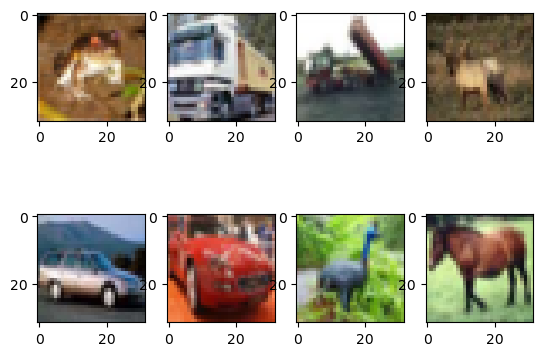

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

Clean labels:
 frog truck truck  deer   car   car  bird horse
Predicted baseline labels:
 frog  ship truck  frog  ship   cat  deer horse


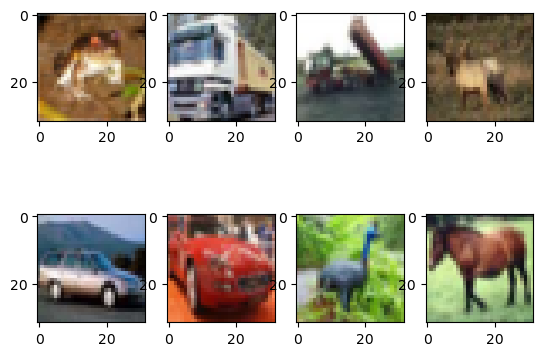

In [7]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
print('Predicted baseline labels:')
print(' '.join('%5s' % classes[int(baseline_model(imgs[j])[0])] for j in range(8)))

### 2.2. Model I

In [12]:


modelI = tf.keras.Sequential([
         tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3)),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(128,(3,3),padding='same', activation ='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(128, activation = 'relu'),
         tf.keras.layers.Dense(64, activation = 'relu'),
         tf.keras.layers.Dropout(0.5),
         tf.keras.layers.Dense(10, activation = 'softmax')])
        
modelI.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss = tf.keras.losses.CategoricalCrossentropy(),
               metrics = ['accuracy'])



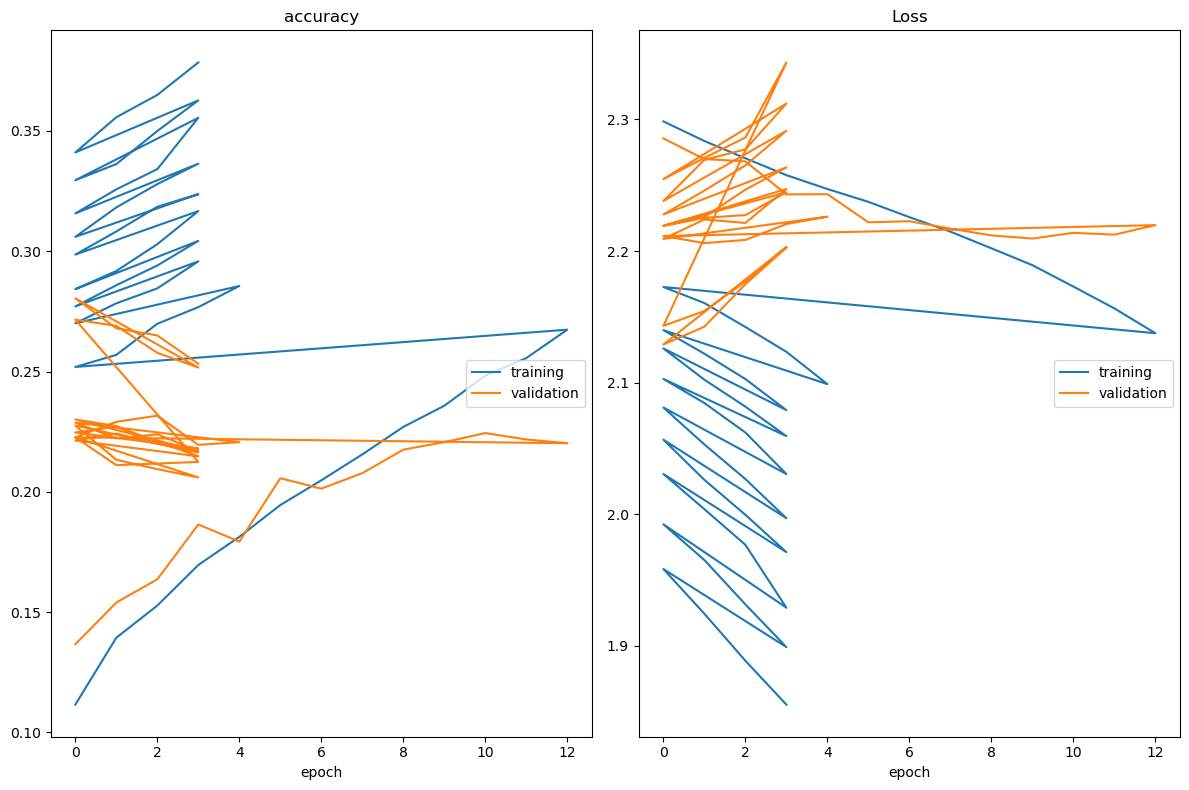

accuracy
	training         	 (min:    0.112, max:    0.378, cur:    0.378)
	validation       	 (min:    0.137, max:    0.280, cur:    0.253)
Loss
	training         	 (min:    1.855, max:    2.299, cur:    1.855)
	validation       	 (min:    2.129, max:    2.343, cur:    2.203)
157/157 [==============================] - 2s 10ms/step - loss: 2.3149 - accuracy: 0.2186
Model evaluation  [2.314906120300293, 0.21860000491142273]
Model Training Time: 23.34 mins


In [13]:
start = time.time()
# Train the slmI model
# ModelCheckpoint callback is used to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
# EarlyStopping stops training when a monitored metric has stopped improving.
# Batch size defines the number of samples to work through before updating the internal model parameters.
# The number of epochs defines the number times that the learning algorithm will work through the entire training dataset.
slm1_checkpoint = ModelCheckpoint(filepath='slm1.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()

n_split=5

for train_index,test_index in KFold(n_split).split(imgs):
  x_train,x_test=imgs[train_index],imgs[test_index]
  y_train,y_test=noisy_labels[train_index],noisy_labels[test_index]
    
  x_train = tf.cast(x_train, dtype='float32')/255.0
  x_test = tf.cast(x_test, dtype='float32')/255.0
  y_train = tf.one_hot(y_train, depth=10)
  y_test = tf.one_hot(y_test, depth=10)
  
  slm1_fit = modelI.fit(x_train, 
                            y_train,
                            batch_size=128, # Mini-batch gradient descent
                            epochs=20,# 20
                            validation_split=0.2, 
                            callbacks=[slm1_checkpoint, early_stop, plot_loss],
                            verbose=1)
  
  print('Model evaluation ',modelI.evaluate(x_test,y_test))
print('Model Training Time:', round((time.time() - start)/60, 2), 'mins')
  

In [16]:
# Prediction & Accuracy
start = dt.now()
modelI.load_weights('slm1.weights.best.hdf5')
modelI_preds = modelI.predict(x_test)
modelI_preds_classes = np.argmax(modelI_preds, axis=1)
slm1_running = (dt.now() - start).microseconds
slm1_acc = accuracy_score(np.argmax(y_test,axis=-1), modelI_preds_classes)
print("slm1 Model Accuracy: {:.2f}%".format(slm1_acc * 100))

157/157 [==============================] - 2s 10ms/step
slm1 Model Accuracy: 21.86%


In [17]:
def model_I(image):
    '''
    This is the MobileNetV3 predictive model that takes in the image and returns a label prediction
    '''
    x_image = tf.cast(image, dtype='float32')/255.0
    
    modelI.load_weights('slm1.weights.best.hdf5')
    slm1_preds = modelI.predict([np.expand_dims(x_image, axis=0)],verbose=0);
    slm1_pred_classes = np.argmax(slm1_preds, axis=1)
    return int(slm1_pred_classes[0])


Clean labels:
 frog truck truck  deer   car   car  bird horse
Predicted baseline labels:
  cat truck truck  frog   car   dog  bird  deer


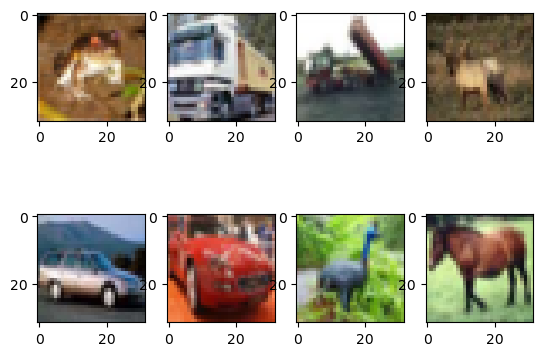

In [18]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
print('Predicted baseline labels:')
print(' '.join('%5s' % classes[model_I(imgs[j])] for j in range(8)))

### 2.3. Model II

In [36]:
# Label cleaning model
imgs_modelII = imgs[:n_clean_noisy]
noisy_labels_modelII = noisy_labels[:n_clean_noisy]

X_train, X_test, y_train, y_test = train_test_split(imgs_modelII, clean_labels, test_size=0.2, random_state=63)
X_train = tf.cast(X_train,dtype='float32')/255.0
X_test = tf.cast(X_test,dtype='float32')/255.0
y_train = tf.one_hot(y_train, depth =10)
#y_test = tf.one_hot(y_test,depth = 10)
start = time.time()

model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3), strides=(1,1)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128,(3,3),padding='same', activation ='relu', strides=(1,1)),
        tf.keras.layers.Conv2D(64,(3,3),padding='same', activation ='relu', strides=(1,1)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        #tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation = 'softmax')])

model.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=25, validation_split= 0.2)
print('Label Cleaning Model Training Time:', round((time.time() - start)/60, 2), 'mins')

Epoch 1/25
100/100 [==============================] - 8s 73ms/step - loss: 2.2137 - accuracy: 0.1633 - val_loss: 1.9668 - val_accuracy: 0.2919
Epoch 2/25
100/100 [==============================] - 7s 72ms/step - loss: 1.9542 - accuracy: 0.2775 - val_loss: 1.7013 - val_accuracy: 0.3775
Epoch 3/25
100/100 [==============================] - 7s 73ms/step - loss: 1.7684 - accuracy: 0.3467 - val_loss: 1.5974 - val_accuracy: 0.4325
Epoch 4/25
100/100 [==============================] - 7s 71ms/step - loss: 1.6338 - accuracy: 0.4027 - val_loss: 1.4947 - val_accuracy: 0.4569
Epoch 5/25
100/100 [==============================] - 7s 72ms/step - loss: 1.5320 - accuracy: 0.4420 - val_loss: 1.4574 - val_accuracy: 0.4638
Epoch 6/25
100/100 [==============================] - 7s 73ms/step - loss: 1.4327 - accuracy: 0.4802 - val_loss: 1.4643 - val_accuracy: 0.4869
Epoch 7/25
100/100 [==============================] - 8s 75ms/step - loss: 1.3356 - accuracy: 0.5195 - val_loss: 1.3074 - val_accuracy: 0.5200

In [37]:
def label_model(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = tf.reshape(image, ((1,) + image.shape))
    predictions = model.predict(image)
    return np.argmax(predictions)

In [38]:
preds = []
acc = []
for i, v in enumerate(X_test):
    pred = label_model(v)
    preds.append(pred)
    if pred == y_test[i]:
        acc.append(1)
    else:
        acc.append(0)
print('Test accuracy:',sum(acc)/len(acc))

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
Test accuracy: 0.5625


In [39]:
### Predict labels from label cleaning model
noisy_images = imgs[n_clean_noisy:]
noisy_images = tf.cast(noisy_images, dtype='float32')/255.0
predicted_labels = np.argmax(model.predict(noisy_images), axis=1)
new_labels = np.append(clean_labels, predicted_labels)

1250/1250 [==============================] - 12s 10ms/step


Noisy labels:
 ship truck  deer   car   dog   cat   cat plane
Predicted clean labels:
 ship   cat plane  frog horse  deer truck plane


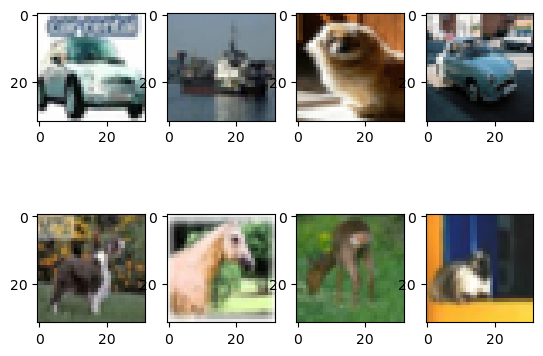

In [42]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[40000]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[40001]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[40002]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[40003]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[40004]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[40005]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[40006]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[40007]/255)

print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in np.arange(40000, 40008, 1)))
print('Predicted clean labels:')
print(' '.join('%5s' % classes[new_labels[j]] for j in np.arange(30000, 30008, 1)))

In [43]:
### Train Model-I with predicted_labels
### MODEL I
x_train, x_test, y_train, y_test = train_test_split(imgs, new_labels, test_size = 0.2, random_state=42)
x_train = tf.cast(x_train, dtype='float32')/255.0
x_test = tf.cast(x_test, dtype='float32')/255.0
y_train = tf.one_hot(y_train, depth=10)
#y_test = tf.one_hot(y_test, depth=10)
start = time.time()

modelII = tf.keras.Sequential([
         tf.keras.layers.Conv2D(32,(3,3),padding='same', activation ='relu', input_shape=(32,32,3)),
         tf.keras.layers.MaxPooling2D((2,2)),
         # tf.keras.layers.Dropout(0.25),
         tf.keras.layers.Conv2D(128,(3,3),padding='same', activation ='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         # tf.keras.layers.Dropout(0.25),
         tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
         tf.keras.layers.MaxPooling2D((2,2)),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(128, activation = 'relu'),
         tf.keras.layers.Dense(64, activation = 'relu'),
         tf.keras.layers.Dropout(0.5),
         tf.keras.layers.Dense(10, activation = 'softmax')])
        
modelII.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss = tf.keras.losses.CategoricalCrossentropy(),
               metrics = ['accuracy'])

modelII.fit(x_train, y_train, batch_size=64, epochs=20, validation_split= 0.2)
print('Model Training Time:', round((time.time() - start)/60, 2), 'mins')

Epoch 1/20
500/500 [==============================] - 29s 58ms/step - loss: 1.8276 - accuracy: 0.3187 - val_loss: 1.4069 - val_accuracy: 0.4868
Epoch 2/20
500/500 [==============================] - 28s 55ms/step - loss: 1.3979 - accuracy: 0.4983 - val_loss: 1.2253 - val_accuracy: 0.5521
Epoch 3/20
500/500 [==============================] - 28s 55ms/step - loss: 1.2382 - accuracy: 0.5627 - val_loss: 1.0875 - val_accuracy: 0.6053
Epoch 4/20
500/500 [==============================] - 27s 55ms/step - loss: 1.1302 - accuracy: 0.6089 - val_loss: 1.0435 - val_accuracy: 0.6267
Epoch 5/20
500/500 [==============================] - 27s 55ms/step - loss: 1.0503 - accuracy: 0.6392 - val_loss: 0.9927 - val_accuracy: 0.6478
Epoch 6/20
500/500 [==============================] - 27s 54ms/step - loss: 0.9731 - accuracy: 0.6654 - val_loss: 1.0279 - val_accuracy: 0.6398
Epoch 7/20
500/500 [==============================] - 28s 55ms/step - loss: 0.9154 - accuracy: 0.6841 - val_loss: 1.0096 - val_accuracy:

In [44]:
y_pred = np.argmax(modelII.predict(x_test), axis=1)
acc = (y_pred==y_test)
print('Model II Test Accuracy:', sum(acc)/len(acc))

313/313 [==============================] - 3s 10ms/step
Model II Test Accuracy: 0.6398


## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.imread(img_fn)
evaluation(model_I, test_labels, test_imgs)

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.imread(img_fn)
evaluation(model_II, test_labels, test_imgs)